# Quantitative labeling comparison
Segmentation algorithms may produce different results. These differences may or may not be crucial, depending on the purpose of the scientific analysis these algorithms are used for.

In this notebook we will check if the number of segmented objects is different using Otsu's thresholding method on blobs.tif and we will check if the area measurements are different between these two algorithms. The visual comparison performed before suggests that there should be a difference in area measurements.

In [1]:
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops
from pyclesperanto_prototype import imshow
from scipy.stats import describe
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ttost_ind

Just as a recap, we take a quick look at the two label images. One was produced in ImageJ, the other using scikit-image.

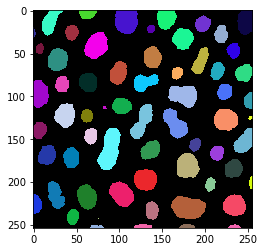

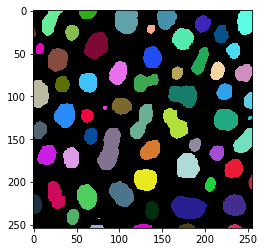

In [22]:
blobs_labels_imagej = imread("blobs_labels_imagej.tif")
blobs_labels_skimage = imread("blobs_labels_skimage.tif")

imshow(blobs_labels_imagej, labels=True)
imshow(blobs_labels_skimage, labels=True)

## Comparing label counts
First, we will count the number of objects in the two images. If the images are labeled subsequently, which means every integer label between 0 and the maximum of the labels exits, the maximum intensity in these label images corresponds to the number of labels present in the image.

In [20]:
blobs_labels_imagej.max(), blobs_labels_skimage.max()

(63, 64)

If the images are not subsequently labeled, we should first determine the unique sets of labels and count them. If background intensity (`0`) is present, these two numbers will be higher by one than the maximum.

In [21]:
len(np.unique(blobs_labels_imagej)), len(np.unique(blobs_labels_skimage))

(64, 65)

Comparing label counts from one single image gives limited insights. It shall be recommended to compare counts from multiple images and apply statistical tests as shown below. With these error analysis methods one can get deeper insights into how different the algorithms are.

## Quantitative comparison
Depending on the desired scientific analysis, the found number of objects may not be relevant, but the area of the found objects might be. Hence, we shoud compare how different area measurements between the algorithms are. Also this should actually be done using multiplel images. We demonstrate it with the single image to make it easisly reproducible.

First, we derive area measurements from the label images and take a quick look.

In [23]:
imagej_statistics = regionprops(blobs_labels_imagej)
imagej_areas = [p.area for p in imagej_statistics]
print(imagej_areas)

[415, 181, 646, 426, 465, 273, 74, 264, 221, 25, 485, 639, 92, 216, 432, 387, 503, 407, 257, 345, 149, 399, 407, 245, 494, 272, 659, 171, 350, 527, 581, 10, 611, 184, 584, 20, 260, 871, 461, 228, 158, 387, 398, 233, 364, 629, 364, 558, 62, 158, 450, 598, 525, 197, 544, 828, 267, 201, 1, 87, 73, 49, 46]


In [24]:
skimage_statistics = regionprops(blobs_labels_skimage)
skimage_areas = [p.area for p in skimage_statistics]
print(skimage_areas)

[433, 185, 658, 434, 477, 285, 81, 278, 231, 30, 501, 660, 99, 228, 448, 401, 520, 425, 271, 350, 159, 412, 426, 260, 506, 289, 676, 175, 361, 545, 610, 14, 641, 195, 593, 22, 268, 902, 473, 239, 167, 413, 415, 244, 377, 652, 379, 578, 69, 170, 472, 613, 543, 204, 555, 858, 281, 215, 3, 1, 81, 90, 53, 49]


Just to confirm our insights from above, we check the number of measurements

In [7]:
len(imagej_areas), len(skimage_areas)

(63, 64)

A simple and yet powerful approach for comparing quantitative measurements visually, is to draw histograms of the measurements, e.g. using [matplotlib's `hist` method](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html). This method works for non-paired data and for paired datasets.

(array([10.,  5., 11.,  5., 12.,  6.,  7.,  5.,  0.,  2.]),
 array([  1.,  88., 175., 262., 349., 436., 523., 610., 697., 784., 871.]),
 <BarContainer object of 10 artists>)

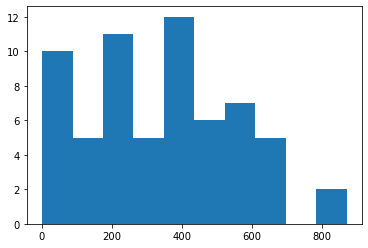

In [8]:
plt.hist(imagej_areas)

(array([11.,  5., 11.,  6., 11.,  6.,  7.,  5.,  0.,  2.]),
 array([  1. ,  91.1, 181.2, 271.3, 361.4, 451.5, 541.6, 631.7, 721.8,
        811.9, 902. ]),
 <BarContainer object of 10 artists>)

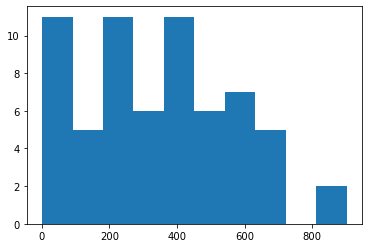

In [9]:
plt.hist(skimage_areas)

The histograms look very similar, and small differences can be identified.

We can nicer to read overview by using scipy's [`describe` method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.describe.html).

In [26]:
describe(imagej_areas)

DescribeResult(nobs=63, minmax=(1, 871), mean=339.8888888888889, variance=43858.100358422926, skewness=0.2985582216973995, kurtosis=-0.5512673189985389)

In [11]:
describe(skimage_areas)

DescribeResult(nobs=64, minmax=(1, 902), mean=347.546875, variance=47422.15649801587, skewness=0.29237468285874324, kurtosis=-0.5465739129172253)

A bit easier to read is the output of [pandas' `describe` mwethod](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html). In order to make it work for our data, we need to create to pandas DataFrames and concatenate them. This is necessary because we have measurements with different lengths ([read more](https://stackoverflow.com/questions/27126511/add-columns-different-length-pandas/33404243)).

In [32]:
table1 = {
    "ImageJ": imagej_areas
}
table2 = {
    "scikit-image": skimage_areas
}

df = pd.concat([pd.DataFrame(table1), pd.DataFrame(table2)], axis=1)
df.describe()

,ImageJ,scikit-image
count,63.000000,64.000000
mean,339.888889,347.546875
std,209.423256,217.766289
min,1.000000,1.000000
25%,182.500000,182.500000
50%,350.000000,355.500000
75%,489.500000,502.250000
max,871.000000,902.000000


## Student's t-test - testing for differences
We now know that the mean of the measurements are different. We should determine if the differences between the measurements are significant. 

We can use the [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) for that using the null-hypothesis: Means of measurements are different. We use the [`ttest_ind` method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) because we do not have paired datasets.

In [12]:
ttest_ind(imagej_areas, skimage_areas)

Ttest_indResult(statistic=-0.20194436015007275, pvalue=0.8402885093667958)

From the printed p-value we can _not_ conclude that differences are insignificant. We can only say that according to the given sample, significance could not be shown.

## Two-sided t-test for equivalence testing
For proving that two algorithms perform similarly and means are different less that a given threshold, we can use a two-sided t-test, e.g. using statsmodels' [`ttost_ind` method](https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ttost_ind.html). Our null-hypothesis: Means of measurements are more than 5% different.

In [15]:
five_percent_error_threshold = 0.05 * (np.mean(imagej_areas) + np.mean(skimage_areas)) / 2
five_percent_error_threshold

17.185894097222224

In [18]:
ttost_ind(imagej_areas, skimage_areas, -five_percent_error_threshold, five_percent_error_threshold)

(0.40101477051276024,
 (0.25125499758118736, 0.40101477051276024, 125.0),
 (-0.6551437178813329, 0.2567895351853574, 125.0))

Note to self: I'm not sure if I interpret the result correctly. I'm also not sure if I use this test correctly. If anyone reads this, and understands why the p-value here is 0.4, please get in touch: robert.haase@tu-dresden.de

In [19]:
ttost_ind?

Signature:
ttost_ind(
    x1,
    x2,
    low,
    upp,
    usevar='pooled',
    weights=(None, None),
    transform=None,
)
Docstring:
test of (non-)equivalence for two independent samples

TOST: two one-sided t tests

null hypothesis:  m1 - m2 < low or m1 - m2 > upp
alternative hypothesis:  low < m1 - m2 < upp

where m1, m2 are the means, expected values of the two samples.

If the pvalue is smaller than a threshold, say 0.05, then we reject the
hypothesis that the difference between the two samples is larger than the
the thresholds given by low and upp.

Parameters
----------
x1 : array_like, 1-D or 2-D
    first of the two independent samples, see notes for 2-D case
x2 : array_like, 1-D or 2-D
    second of the two independent samples, see notes for 2-D case
low, upp : float
    equivalence interval low < m1 - m2 < upp
usevar : str, 'pooled' or 'unequal'
    If ``pooled``, then the standard deviation of the samples is assumed to be
    the same. If ``unequal``, then Welch ttest wit